In [ ]:
# Going to use TrashCAN 1.0 Dataset (https://conservancy.umn.edu/handle/11299/214865)
# Specifically, use TrashCAN-Material sub-dataset with the following classes:

'''
 'rov': 0,
 'plant': 1,
 'animal_fish': 2,
 'animal_starfish': 3,
 'animal_shells': 4,
 'animal_crab': 5,
 'animal_eel': 6,
 'animal_etc': 7,
 'trash_etc': 8,
 'trash_fabric': 9,
 'trash_fishing_gear': 10,
 'trash_metal': 11,
 'trash_paper': 12,
 'trash_plastic': 13,
 'trash_rubber': 14,
 'trash_wood': 15
'''

# Reference paper: https://arxiv.org/pdf/2007.08097.pdf

# This dataset includes both detection and segmentation labels (going to just focus on detection)


##**Setup of Environment and Datasets**

In [ ]:
# for debugging
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [ ]:
import json
from PIL import Image
from PIL import ImageDraw
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import pycocotools
import numpy as np
import copy
import math

# pickle compatibility:
# because lower pandas version used in colab, make sure pickle files are protocol = 4

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
os.chdir('/content/gdrive/MyDrive/UTD')

In [ ]:
# define the torchvision image transforms
# here just the basic transform which converts an input image to a tensor
# later, can include data augmentation here, like transforms.RandomHorizontalFlip(0.5) (just add to the list)
# note that data augmentation will only be performed on training data

transform = transforms.Compose([
    transforms.ToTensor(),
])

In [ ]:
# construct Dataset class for pytorch

class UnderwaterTrashDataset(torch.utils.data.Dataset):
    '''
    Pytorch Dataset class for Underwater Trash Dataset (Trash_CAN 1.0)
    
    data_file_path := path to pickle file containing dataset (annotations and filenames to images)
    images_path := path to folder containing actual image files
    transforms := data transformation and augmentation
    '''
    
    def __init__(self, data_file_path, images_path, transforms=None):
        if data_file_path:
            self.data = pd.read_pickle(data_file_path)
            self.classes = self.data.category_id.unique()
        self.images_path = images_path
        self.transforms = transforms
    
    
    def __getitem__(self, idx):
        temp = self.data[self.data.image_id == idx]
        
        image = Image.open(os.path.join(self.images_path, temp.file_name.iloc[0])).convert("RGB")
        
        box_list = copy.deepcopy(list(temp.bbox))

        for box in box_list: # xmax = xmin + width, ymax = ymin + height
            box[2] = box[2] + box[0]
            box[3] = box[3] + box[1]
        
        box_list = torch.as_tensor(box_list, dtype=torch.float32)
        
        labels = torch.as_tensor(temp.category_id.values - 1, dtype=torch.int64)
        # labels = torch.as_tensor(temp.category_id.values, dtype=torch.int64)
        
        image_id = torch.tensor([idx])
        
        area = (box_list[:, 3] - box_list[:, 1]) * (box_list[:, 2] - box_list[:,0])
        
        iscrowd = torch.zeros((len(box_list),), dtype=torch.int64)
        
        target = {}
        target["boxes"] = box_list
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd
        
        if self.transforms:
            image = self.transforms(image)
            
        return image, target

    
    def __len__(self):
        return self.data.image_id.nunique()
    
    
 

In [ ]:
# instantiate datasets

train = UnderwaterTrashDataset('/content/gdrive/MyDrive/UTD/UTD_train.pkl', '/content/gdrive/MyDrive/UTD/material_version/train/', transforms=transform)
val = UnderwaterTrashDataset('/content/gdrive/MyDrive/UTD/UTD_val.pkl', '/content/gdrive/MyDrive/UTD/material_version/val/', transforms=transform)
test = UnderwaterTrashDataset('/content/gdrive/MyDrive/UTD/UTD_test.pkl', '/content/gdrive/MyDrive/UTD/material_version/test/', transforms=transform)

In [ ]:
train[1]

(tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0118, 0.0118, 0.0118,  ..., 0.0000, 0.0000, 0.0000],
          [0.0157, 0.0157, 0.0157,  ..., 0.0157, 0.0157, 0.0157],
          [0.0235, 0.0235, 0.0235,  ..., 0.0314, 0.0314, 0.0314]],
 
         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
 
         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ...,

In [ ]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [ ]:
# loads in the model and adjusts the last layer to output the correct number of classes
# change this later

def get_model(num_classes):
   # load an object detection model pre-trained on COCO
   model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

   # get the number of input features for the classifier
   in_features = model.roi_heads.box_predictor.cls_score.in_features

   # replace the pre-trained head with a new one
   model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
   
   return model

In [ ]:
# need to copy training reference file from torch repo:
# os.mkdir('/content/gdrive/MyDrive/torch_training_ref')
os.chdir('/content/gdrive/MyDrive/torch_training_ref')

In [ ]:
%%bash
git clone https://github.com/pytorch/vision.git
cd vision
cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

fatal: destination path 'vision' already exists and is not an empty directory.


In [ ]:
# define training and validation data loaders
data_loader_train = torch.utils.data.DataLoader(train, batch_size=8, 
                                                shuffle=True, num_workers=2,
                                                collate_fn=collate_fn)

data_loader_val = torch.utils.data.DataLoader(val, batch_size=8,
                                              shuffle=False, num_workers=2,
                                              collate_fn=collate_fn)


##**Training**

In [ ]:
torch.cuda.is_available() # check GPU availability

True

In [ ]:
# change these hyperparams later

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has 16 classes (see list above)
num_classes = 16

# get the model using our helper function
model = get_model(num_classes)

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.002,
                            momentum=0.9, weight_decay=0.0001)

# and a learning rate scheduler which decreases the learning rate by # 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

In [ ]:
from engine import train_one_epoch, evaluate

# let's train it for 10 epochs
num_epochs = 10

for epoch in range(num_epochs):
   # train for one epoch, printing every 10 iterations
   train_one_epoch(model, optimizer, data_loader_train, device, epoch, print_freq=10)
   
   # update the learning rate
   lr_scheduler.step()
   # evaluate on the test dataset
   evaluate(model, data_loader_val, device=device)

   

Epoch: [0]  [  0/751]  eta: 1:13:57  lr: 0.000005  loss: 3.4904 (3.4904)  loss_classifier: 3.2416 (3.2416)  loss_box_reg: 0.1136 (0.1136)  loss_objectness: 0.0909 (0.0909)  loss_rpn_box_reg: 0.0443 (0.0443)  time: 5.9084  data: 4.4553  max mem: 9526
Epoch: [0]  [ 10/751]  eta: 0:30:10  lr: 0.000031  loss: 3.3459 (3.3280)  loss_classifier: 3.1630 (3.1217)  loss_box_reg: 0.1108 (0.1150)  loss_objectness: 0.0613 (0.0660)  loss_rpn_box_reg: 0.0195 (0.0253)  time: 2.4427  data: 1.0575  max mem: 9793
Epoch: [0]  [ 20/751]  eta: 0:28:24  lr: 0.000058  loss: 2.9926 (2.9498)  loss_classifier: 2.8832 (2.7599)  loss_box_reg: 0.1091 (0.1088)  loss_objectness: 0.0507 (0.0609)  loss_rpn_box_reg: 0.0154 (0.0202)  time: 2.1525  data: 0.7744  max mem: 9793
Epoch: [0]  [ 30/751]  eta: 0:26:55  lr: 0.000085  loss: 1.7438 (2.3842)  loss_classifier: 1.6265 (2.2012)  loss_box_reg: 0.0961 (0.1075)  loss_objectness: 0.0383 (0.0570)  loss_rpn_box_reg: 0.0140 (0.0185)  time: 2.1299  data: 0.7502  max mem: 9793


##**Running Inference**

In [ ]:
os.mkdir("/content/gdrive/MyDrive/UTD/fasterRCNN_results")
torch.save(model.state_dict(), "/content/gdrive/MyDrive/UTD/fasterRCNN_results/model")

In [ ]:
loaded_model = get_model(num_classes = 16)
loaded_model.load_state_dict(torch.load('/content/gdrive/MyDrive/UTD/fasterRCNN_results/model'))

<All keys matched successfully>

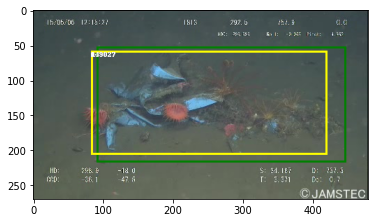

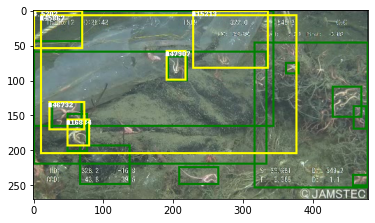

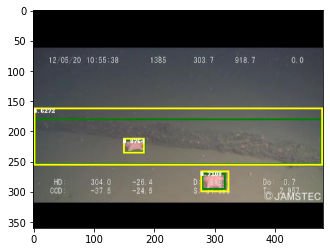

In [ ]:
test_df = pd.read_pickle('/content/gdrive/MyDrive/UTD/UTD_test.pkl')
files = ['vid_000077_frame0000020.jpg', 'vid_000090_frame0000051.jpg', 'vid_000106_frame0000027.jpg']
i = 0

for im_file in files:
  temp = test_df[test_df.file_name == im_file]
  idx = temp.image_id.values[0]
  labels = list(temp.category_id.values)
  img, _ = test[idx]
  label_boxes = np.array(test[idx][1]["boxes"])

  loaded_model.eval()
  with torch.no_grad():
    prediction = loaded_model([img])
  image = Image.fromarray(img.mul(255).permute(1, 2,0).byte().numpy())
  draw = ImageDraw.Draw(image)

  # draw groundtruth
  for elem in range(len(label_boxes)):
    draw.rectangle([(label_boxes[elem][0], label_boxes[elem][1]),
    (label_boxes[elem][2], label_boxes[elem][3])], 
    outline ="green", width =3)

  # draw predictions
  for element in range(len(prediction[0]["boxes"])):
    boxes = prediction[0]["boxes"][element].cpu().numpy()
    score = np.round(prediction[0]["scores"][element].cpu().numpy(), decimals= 4)
    if score > 0.5:
        draw.rectangle([(boxes[0], boxes[1]), (boxes[2], boxes[3])], 
        outline ="yellow", width =3)
        draw.text((boxes[0], boxes[1]), text = str(score))
        draw.text((boxes[0], boxes[1]), text = str(labels[element]))
  plt.figure(i)
  plt.imshow(image)
  i += 1